In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import os

# Define the source and destination folders
source_folder = "/content/drive/MyDrive/Satriya Dance Mudra Detection.v1i.yolov8/valid/images"
destination_folder = "/content/drive/MyDrive/Project/SkeletalSegmentation"


# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Define the skeletal segmentation function using morphological skeletonization
def skeleton_segmentation(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding (adjust the threshold value as needed)
   # _, thresholded = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    thresholded = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2) #Adaptive Thresholding

    # Perform morphological skeletonization
    skeleton = cv2.ximgproc.thinning(thresholded)

    return skeleton

# Iterate through all files in the source folder
for filename in os.listdir(source_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Add more image formats as needed
        # Read the image
        image_path = os.path.join(source_folder, filename)
        image = cv2.imread(image_path)

        if image is not None:
            # Perform skeletal segmentation
            segmented_image = skeleton_segmentation(image)

            # Save the segmented image to the destination folder
            destination_path = os.path.join(destination_folder, filename)
            cv2.imwrite(destination_path, segmented_image)
            print(f"Skeletal segmented and saved {filename} to {destination_path}")

print("Skeletal segmentation and saving completed.")

Skeletal segmented and saved unscreen-053_png.rf.626aec9d14c46e7a442dcf9e88384427.jpg to /content/drive/MyDrive/Project/SkeletalSegmentation/unscreen-053_png.rf.626aec9d14c46e7a442dcf9e88384427.jpg
Skeletal segmented and saved unscreen-086_png.rf.665346bfa45700354bb3739f18dff1cf.jpg to /content/drive/MyDrive/Project/SkeletalSegmentation/unscreen-086_png.rf.665346bfa45700354bb3739f18dff1cf.jpg
Skeletal segmented and saved unscreen-028_png.rf.630c6039efc4c9e73f3c2507c1cdbac4.jpg to /content/drive/MyDrive/Project/SkeletalSegmentation/unscreen-028_png.rf.630c6039efc4c9e73f3c2507c1cdbac4.jpg
Skeletal segmented and saved unscreen-141_png.rf.60e3ffdab990dc2f6115b8cdfe9032de.jpg to /content/drive/MyDrive/Project/SkeletalSegmentation/unscreen-141_png.rf.60e3ffdab990dc2f6115b8cdfe9032de.jpg
Skeletal segmented and saved unscreen-036_png.rf.65259ed5b7466f195dfd95fbb175c039.jpg to /content/drive/MyDrive/Project/SkeletalSegmentation/unscreen-036_png.rf.65259ed5b7466f195dfd95fbb175c039.jpg
Skeletal s

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

def extract_features(skeletal_image):
    """
    Extracts features from a skeletal image, handling potential empty images.

    Args:
        skeletal_image: A grayscale image representing the hand skeleton.

    Returns:
        A dictionary containing extracted features (or None if image is empty), and keypoints list.
    """

    features = {}
    keypoints = []

    # Check if image is empty
    if skeletal_image.size == 0:
        print("Error: Empty image provided. Skipping feature extraction.")
        return None, keypoints

    # Find contours (connected components) representing fingers
    contours, _ = cv2.findContours(skeletal_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract keypoint locations (endpoints of contours)
    for cnt in contours:
        # Get the top-most, bottom-most, left-most, and right-most points
        x, y, w, h = cv2.boundingRect(cnt)
        keypoints.append((x, y))  # Top-left corner (assuming fingertip)
        keypoints.append((x + w - 1, y + h - 1))  # Bottom-right corner

    # Calculate distances between keypoints
    distances = {}
    for i in range(len(keypoints) - 1):
        for j in range(i + 1, len(keypoints)):
            x1, y1 = keypoints[i]
            x2, y2 = keypoints[j]
            dist = cv2.norm(np.array([x1, y1]), np.array([x2, y2]))
            distances[f"keypoint_{i+1}_to_{j+1}"] = dist  # Descriptive names

    # Calculate moments (centroid) with error handling
    try:
        moments = cv2.moments(skeletal_image)
        center_x = int(moments["m10"] / moments["m00"])
        center_y = int(moments["m01"] / moments["m00"])
        features["centroid"] = (center_x, center_y)
    except ZeroDivisionError:
        print("Warning: Moment calculation failed (likely empty image). Skipping centroid.")

    features.update(distances)  # Add distances to features dictionary

    return features, keypoints

def plot_features(original_image, features, keypoints):
    """
    Plots extracted features on the original image.

    Args:
        original_image: The original grayscale image of the hand.
        features: A dictionary containing extracted features from the skeleton.
        keypoints: A list of keypoints extracted from the skeleton.
    """

    plt.imshow(original_image, cmap='gray')  # Plot grayscale image
    plt.title(f"Extracted Features Visualization")

    # Plot keypoints as red circles
    for kp in keypoints:
        plt.plot(kp[0], kp[1], marker="o", color="red", markersize=5)

    # Plot lines based on distances (adjust based on keypoint order)
    for i in range(len(keypoints) - 1):
        start_point = keypoints[i]
        end_point = keypoints[i + 1]
        plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], color="blue")

    # Plot centroid if available
    if "centroid" in features:
        centroid_x, centroid_y = features["centroid"]
        plt.plot(centroid_x, centroid_y, marker="*", markersize=10, color="green")  # Green star for centroid

    plt.axis("off")  # Hide axes for cleaner visualization
    plt.show()

# Access all images in the directory
image_path = "/content/drive/MyDrive/Project/SkeletalSegmentation"  # Replace with your path
images = []
for filename in os.listdir(image_path):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        img = cv2.imread(os.path.join(image_path, filename), cv2.IMREAD_GRAYSCALE)
        images.append(img)

# Process each image and plot features
for img in images:
    features, keypoints = extract_features(img)
    if features:
        plot_features(img, features, keypoints)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'/content/drive/MyDrive/Project/SkeletalSegmentation/*.jpg'):
      display(Image(filename=image_path, height = 200))
      print("/n")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2
import os
import numpy as np

# Define the source and destination folders
source_folder = "/content/drive/MyDrive/Satriya Dance Mudra Detection.v1i.yolov8/valid/images"
destination_folder = "/content/drive/MyDrive/Project/SkinColorBased_Segmentation"

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Define the skin color range in HSV color space (you may need to adjust these values)

lower_skin = np.array([0, 20, 70], dtype=np.uint8)
upper_skin = np.array([20, 255, 255], dtype=np.uint8)

#lower_skin = np.array([0, 1, 0], dtype=np.uint8)
#upper_skin = np.array([10, 255, 53], dtype=np.uint8)

#Aggregate Lower Skin Color Bounds (Hue, Saturation, Value): [0 1 0]
#Aggregate Upper Skin Color Bounds (Hue, Saturation, Value): [ 10 255  53]

# Define the skin color-based segmentation function
def skin_color_segmentation(image):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Create a mask to identify skin color pixels
    mask = cv2.inRange(hsv, lower_skin, upper_skin)

    # Apply bitwise AND operation to segment the skin regions
    segmented_image = cv2.bitwise_and(image, image, mask=mask)

    return segmented_image

# Iterate through all files in the source folder
for filename in os.listdir(source_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Add more image formats as needed
        # Read the image
        image_path = os.path.join(source_folder, filename)
        image = cv2.imread(image_path)

        if image is not None:
            # Perform skin color-based segmentation
            segmented_image = skin_color_segmentation(image)

            # Save the segmented image to the destination folder
            destination_path = os.path.join(destination_folder, filename)
            cv2.imwrite(destination_path, segmented_image)
            print(f"Skin color segmented and saved {filename} to {destination_path}")

print("Skin color segmentation and saving completed.")


Skin color segmented and saved unscreen-053_png.rf.626aec9d14c46e7a442dcf9e88384427.jpg to /content/drive/MyDrive/Project/SkinColorBased_Segmentation/unscreen-053_png.rf.626aec9d14c46e7a442dcf9e88384427.jpg
Skin color segmented and saved unscreen-086_png.rf.665346bfa45700354bb3739f18dff1cf.jpg to /content/drive/MyDrive/Project/SkinColorBased_Segmentation/unscreen-086_png.rf.665346bfa45700354bb3739f18dff1cf.jpg
Skin color segmented and saved unscreen-028_png.rf.630c6039efc4c9e73f3c2507c1cdbac4.jpg to /content/drive/MyDrive/Project/SkinColorBased_Segmentation/unscreen-028_png.rf.630c6039efc4c9e73f3c2507c1cdbac4.jpg
Skin color segmented and saved unscreen-141_png.rf.60e3ffdab990dc2f6115b8cdfe9032de.jpg to /content/drive/MyDrive/Project/SkinColorBased_Segmentation/unscreen-141_png.rf.60e3ffdab990dc2f6115b8cdfe9032de.jpg
Skin color segmented and saved unscreen-036_png.rf.65259ed5b7466f195dfd95fbb175c039.jpg to /content/drive/MyDrive/Project/SkinColorBased_Segmentation/unscreen-036_png.rf.65

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'/content/drive/MyDrive/Project/SkinColorBased_Segmentation/*.jpg'):
      display(Image(filename=image_path, height = 200))
      print("/n")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!nvidia-smi

Mon Dec 25 09:03:55 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.0/715.0 kB 4.1 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import os
from IPython.display import display, Image
from IPython import display
display.clear_output()
!yolo mode=checks

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 509, in entrypoint
    raise ValueError(f"Invalid 'mode={mode}'. Valid modes are {MODES}.\n{CLI_HELP_MSG}")
ValueError: Invalid 'mode=<module 'ultralytics.utils.checks' from '/usr/local/lib/python3.10/dist-packages/ultralytics/utils/checks.py'>'. Valid modes are ('train', 'val', 'predict', 'export', 'track', 'benchmark').

    Arguments received: ['yolo', 'mode=checks']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of ('detect', 'segment', 'classify', 'pose', 'obb')
                MODE (required) is one of ('train', 'val', 'predict', 'export', 'track', 'benchmark')
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS at ht

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="3ehT9yD2Z1q3e5vQAwxt")
project = rf.workspace("dishanka-kalita").project("satriya-dance-mudra-detection")
dataset = project.version(4).download("yolov8")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstal

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.229, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Satriya-Dance-Mudra-Detection-4 in yolov8:: 100%|██████████| 10476/10476 [00:01<00:00, 6264.59it/s]


In [ ]:
!yolo task = detect mode = train model = yolov8m.pt data = {dataset.location}/data.yaml epochs = 50 batch=16 imgsz=640

Ultralytics YOLOv8.0.229 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/Satriya-Dance-Mudra-Detection-4/data.yaml, epochs=50, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!cp -r /content/runs/detect /content/drive/MyDrive/Project/YOLO_runs

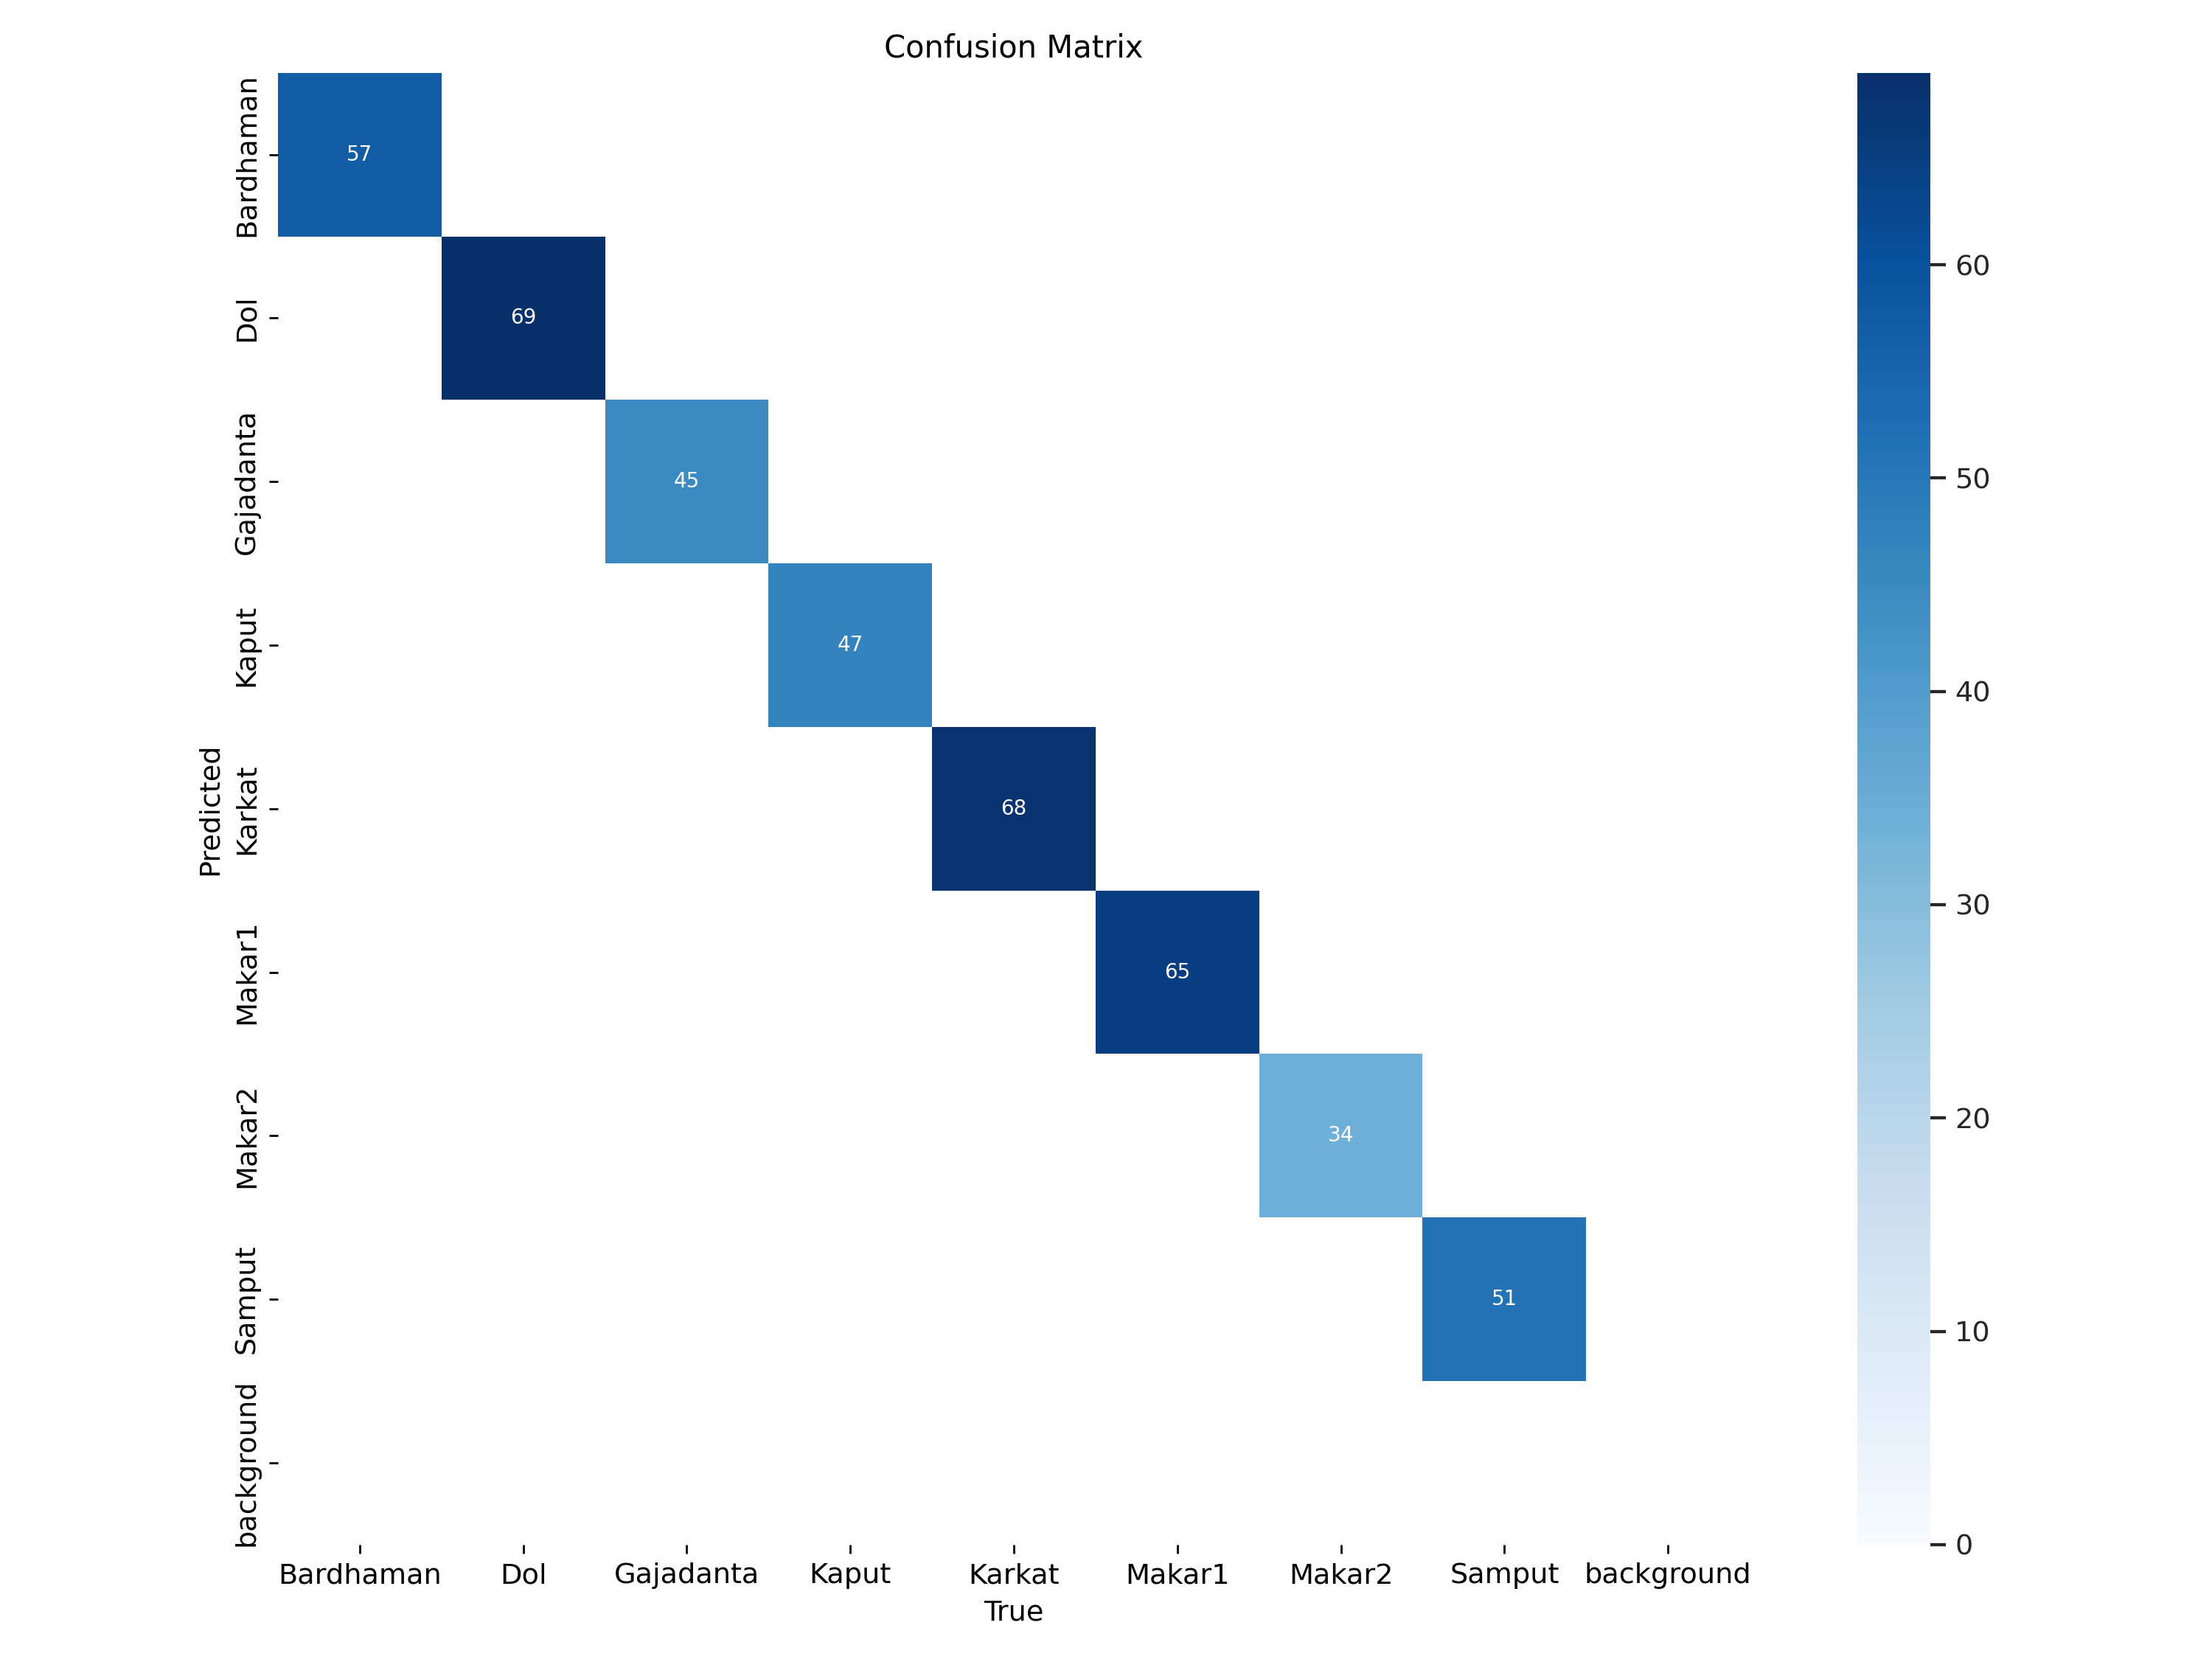

In [ ]:
Image(filename=f'/content/runs/detect/train/confusion_matrix.png', width = 600)

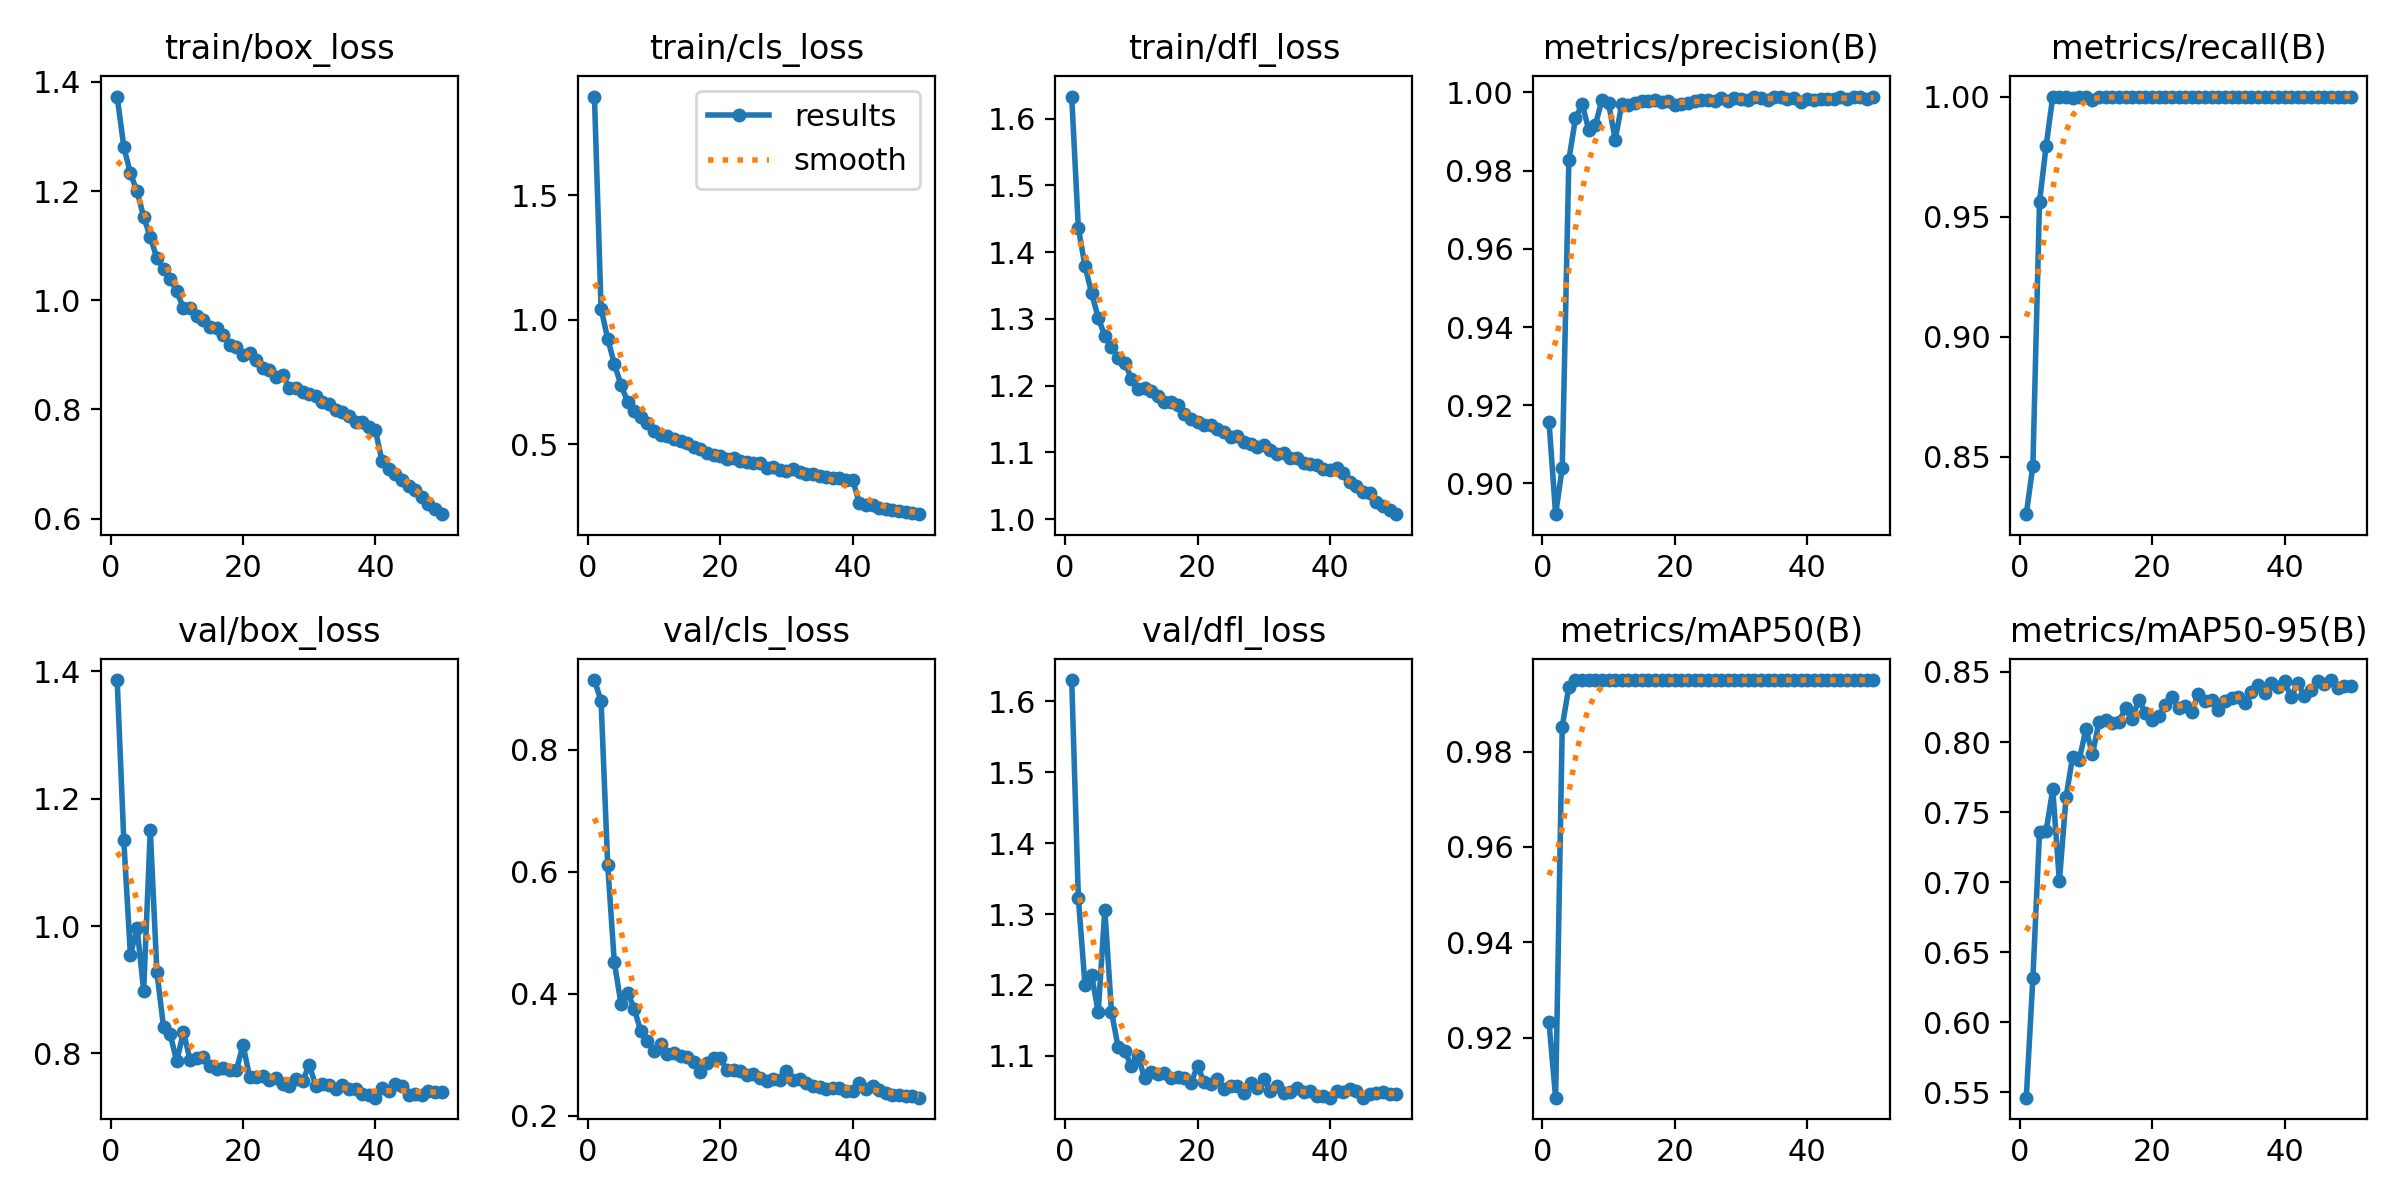

In [ ]:
Image(filename=f'/content/runs/detect/train/results.png', width = 600)

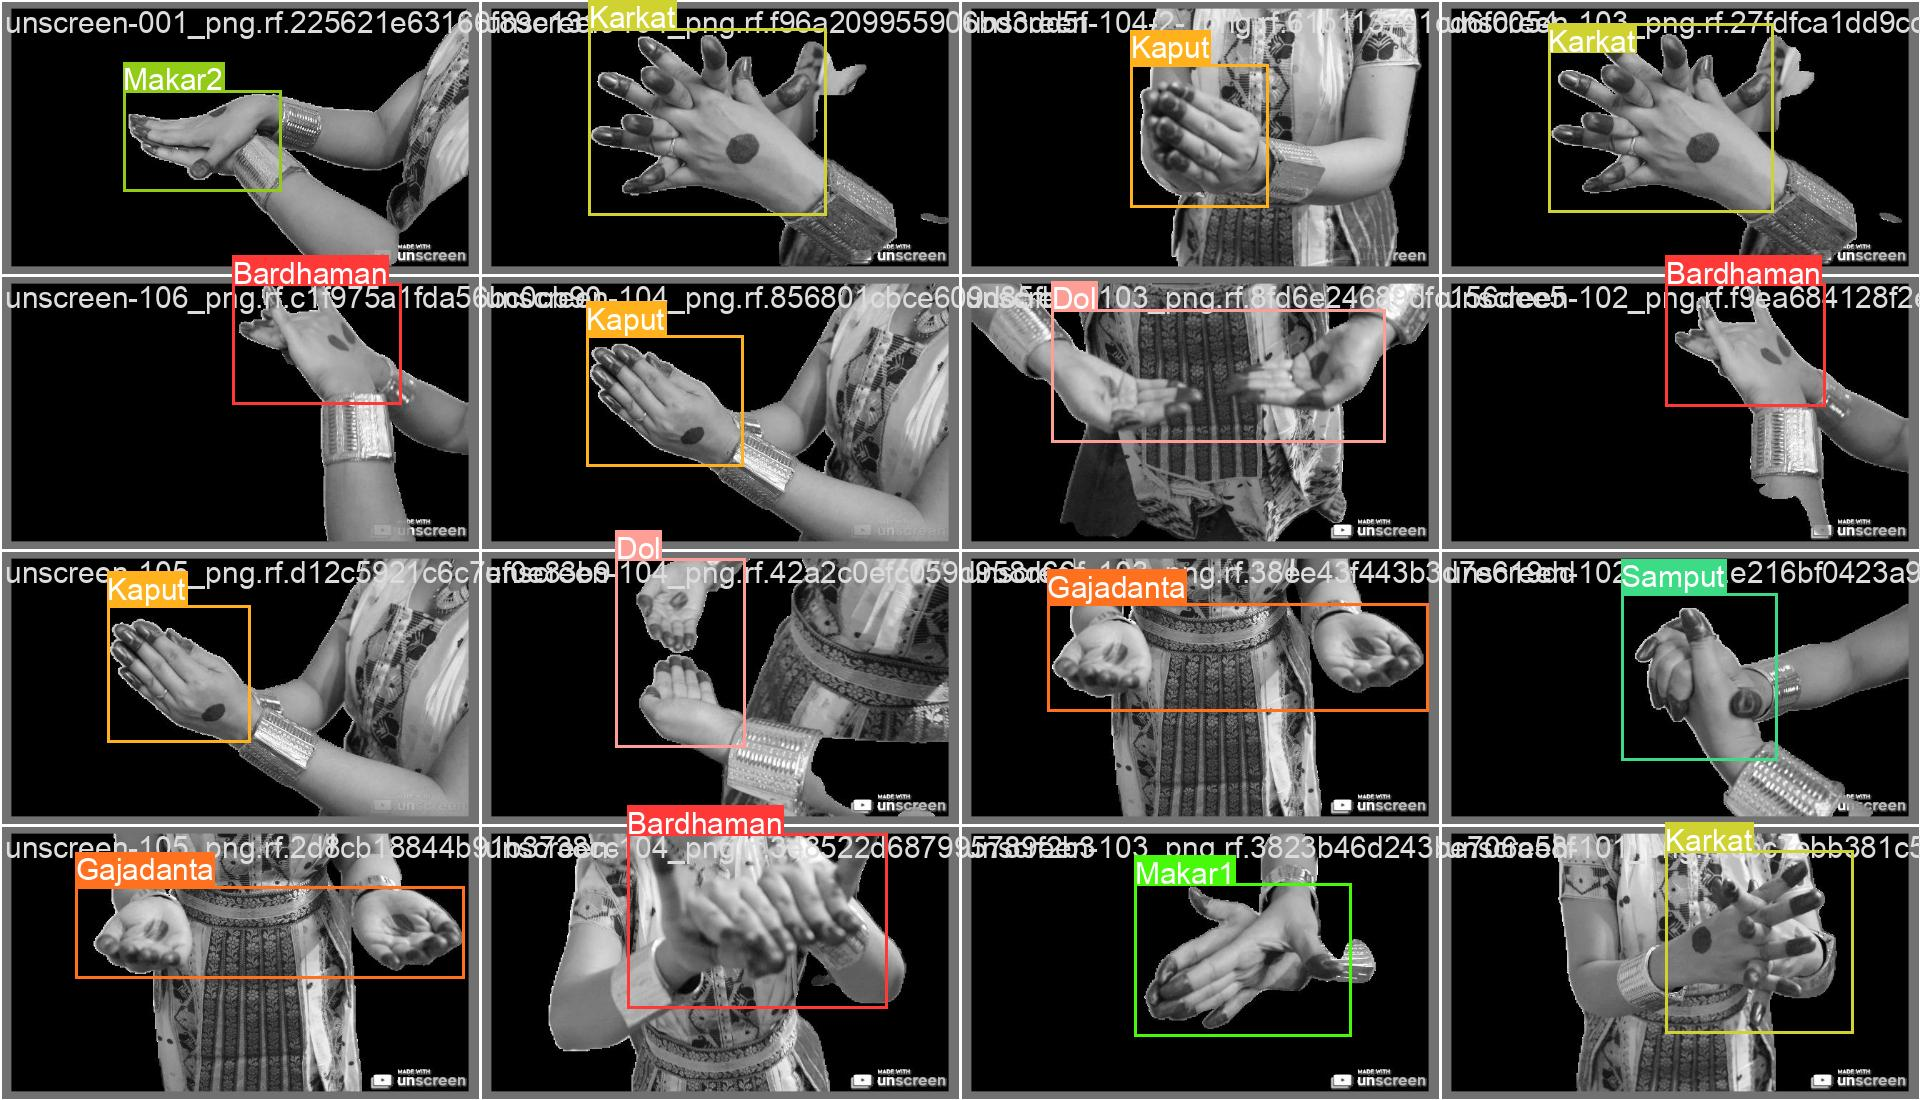

In [ ]:
Image(filename=f'/content/runs/detect/train/val_batch0_labels.jpg', width = 600)

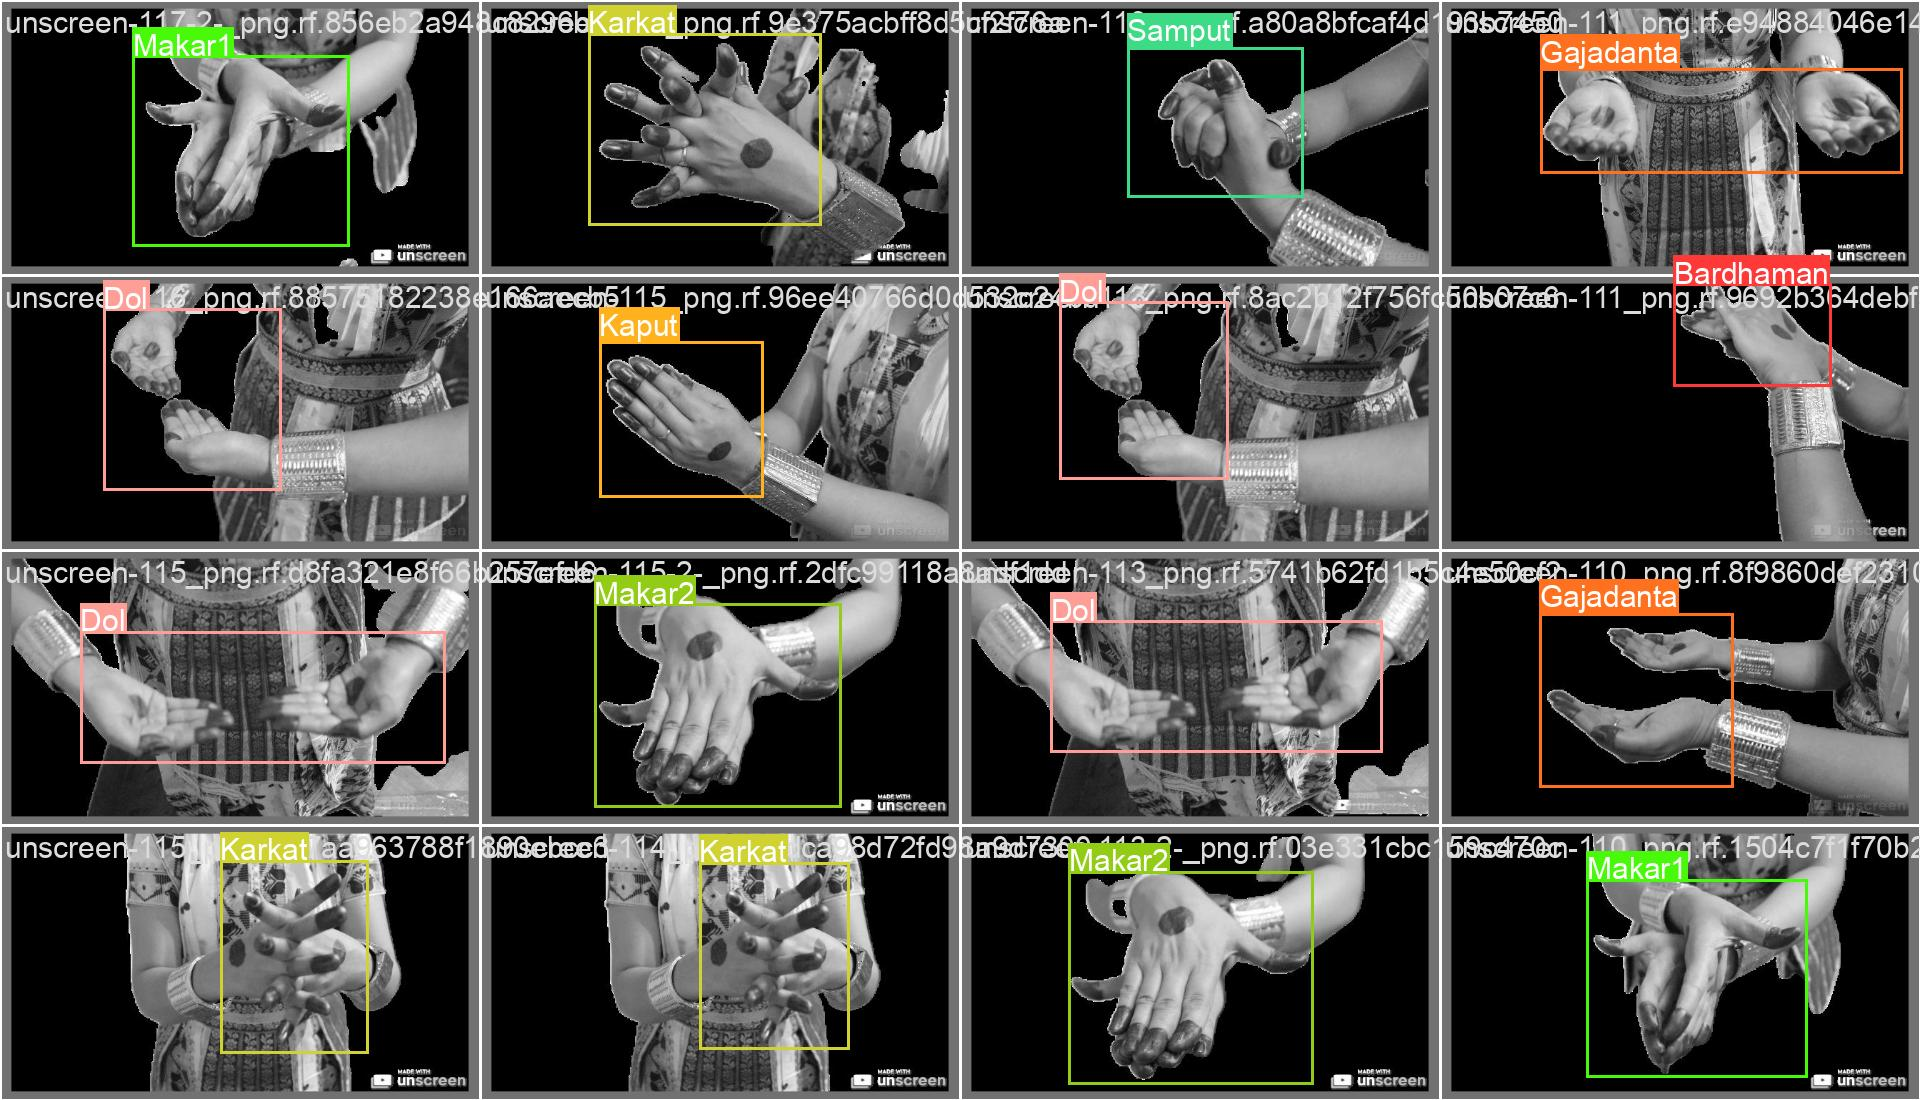

In [ ]:
Image(filename=f'/content/runs/detect/train/val_batch1_labels.jpg', width = 600)

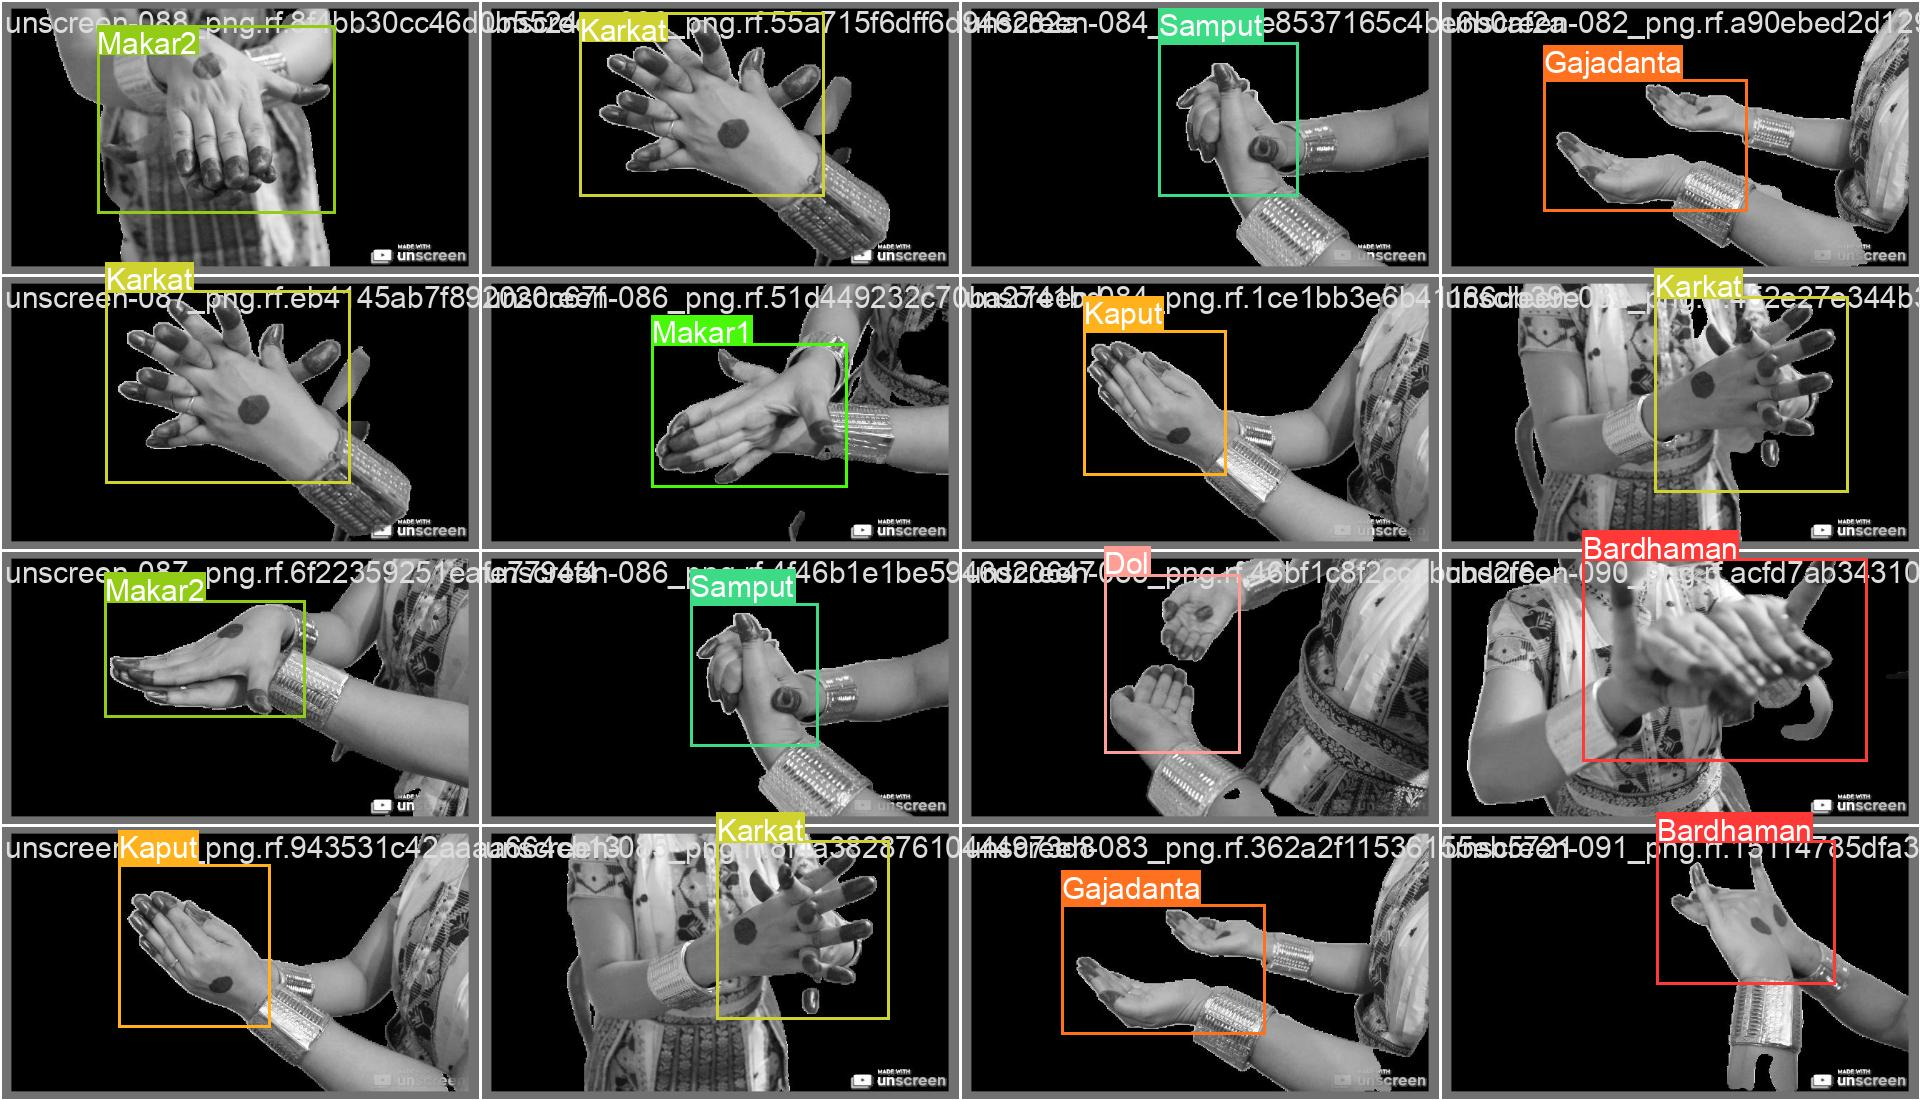

In [ ]:
Image(filename=f'/content/runs/detect/train/val_batch2_labels.jpg', width = 600)

In [ ]:
!yolo task = detect mode = val model = /content/runs/detect/train/weights/best.pt data = {dataset.location}/data.yaml

Ultralytics YOLOv8.0.208 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25844392 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/Satriya-Dance-Mudra-Detection-4/valid/labels.cache... 436 images, 0 backgrounds, 0 corrupt: 100% 436/436 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 28/28 [00:09<00:00,  3.05it/s]
                   all        436        436      0.999          1      0.995      0.844
             Bardhaman        436         57      0.999          1      0.995      0.781
                   Dol        436         69      0.998          1      0.995      0.829
             Gajadanta        436         45          1          1      0.995      0.849
                 Kaput        436         47          1          1      0.995      0.828
                Karkat        436         68      0.998          1      0.995      0.827
                Makar1    

In [ ]:
!yolo task = detect mode = predict model = /content/runs/detect/train/weights/best.pt conf= 0.5 source = {dataset.location}/test/images save_txt=true save_txt

Ultralytics YOLOv8.0.208 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25844392 parameters, 0 gradients, 78.7 GFLOPs

image 1/218 /content/Satriya-Dance-Mudra-Detection-4/test/images/unscreen-002_png.rf.5b5bb8c0e242cd3fa621a1de7b466f3e.jpg: 384x640 1 Gajadanta, 114.2ms
image 2/218 /content/Satriya-Dance-Mudra-Detection-4/test/images/unscreen-002_png.rf.70f164f56e4dd7cd97a4e0e82de54a1b.jpg: 384x640 1 Makar1, 25.8ms
image 3/218 /content/Satriya-Dance-Mudra-Detection-4/test/images/unscreen-003_png.rf.81cdd81143453a75801f5ec8d734e01b.jpg: 384x640 1 Gajadanta, 25.7ms
image 4/218 /content/Satriya-Dance-Mudra-Detection-4/test/images/unscreen-003_png.rf.e2bae66473fa51d1d82e503f7826858c.jpg: 384x640 1 Makar1, 25.7ms
image 5/218 /content/Satriya-Dance-Mudra-Detection-4/test/images/unscreen-004_png.rf.336b737efb49648305a807e67329d5a7.jpg: 384x640 1 Makar1, 25.3ms
image 6/218 /content/Satriya-Dance-Mudra-Detection-4/test/images/unscreen-005_png.r

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg'):
      display(Image(filename=image_path, height = 200))
      print("/n")

In [ ]:
from google.colab import files
from ultralytics import YOLO

# Upload an image using the Colab file uploader
uploaded = files.upload()

# Get the path to the uploaded image
image_path = next(iter(uploaded.keys()))

# Load a pretrained YOLOv8 model
model = YOLO('/content/drive/MyDrive/Project/YOLO_runs/detect/train2/weights/best.pt')

# Specify the output directory
output_dir = '/content/drive/MyDrive/Project/YOLO_Output'

# Run inference on the uploaded image and save the results to the specified directory
results = model(image_path, conf=0.4, save=True, project=output_dir)


ModuleNotFoundError: No module named 'ultralytics'

In [ ]:
!ffmpeg -i {/content/drive/MyDrive/Project/YOLO_Output/predict11} -vcodec libx264 {"final.mp4"}

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab